# 01. PyTorch Workflow Fundamentals

The essence of machine learning and deep learning is to take some data from the past, build an algorithm (like a neural network) to discover patterns in it and use the discoverd patterns to predict the future.

## What we're going to cover

In this module we're going to cover a standard PyTorch workflow (it can be chopped and changed as necessary but it covers the main outline of steps).

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png" width=900 alt="a pytorch workflow flowchat"/>

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **1. Getting data ready** | Data can be almost anything but to get started we're going to create a simple straight line |
| **2. Building a model** | Here we'll create a model to learn patterns in the data, we'll also choose a **loss function**, **optimizer** and build a **training loop**. | 
| **3. Fitting the model to data (training)** | We've got data and a model, now let's let the model (try to) find patterns in the (**training**) data. |
| **4. Making predictions and evaluating a model (inference)** | Our model's found patterns in the data, let's compare its findings to the actual (**testing**) data. |
| **5. Saving and loading a model** | You may want to use your model elsewhere, or come back to it later, here we'll cover that. |
| **6. Putting it all together** | Let's take all of the above and combine it. |

We're going to get torch, `torch.nn` (nn stands for neural network and this package contains the building blocks for creating neural networks in PyTorch) and matplotlib.

In [149]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1+cu117'

## 1. Data (preparing and loading)

We'll use linear regression to create the data with **known parameters** (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.

In [150]:
#  Create known parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(1) # unsqueeze adds a dimension of size 1
y = weight * X + bias

X.shape, y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

### Split data into training and test sets 

One of most important steps in a machine learning project is creating a training and test set (and when required, a validation set).

Each split of the dataset serves a specific purpose:

| Split | Purpose | Amount of total data | How often is it used? |
| ----- | ----- | ----- | ----- |
| **Training set** | The model learns from this data (like the course materials you study during the semester). | ~60-80% | Always |
| **Validation set** | The model gets tuned on this data (like the practice exam you take before the final exam). | ~10-20% | Often but not always |
| **Testing set** | The model gets evaluated on this data to test what it has learned (like the final exam you take at the end of the semester). | ~10-20% | Always |

For now, we'll just use a training and test set, this means we'll have a dataset for our model to learn on as well as be evaluated on.

We can create them by splitting our `X` and `y` tensors.

> **Note:** When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn on training data and then evaluate it on test data to get an indication of how well it **generalizes** to unseen examples.


In [151]:
# Create a train/test split
train_split  = int (0.8 * len(X))
X_train, X_test = X[:train_split], X[train_split:]
y_train, y_test = y[:train_split], y[train_split:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([40, 1]),
 torch.Size([40, 1]),
 torch.Size([10, 1]),
 torch.Size([10, 1]))

In [152]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
    """
    Plots training data, test data and compares predictions if not None.
    
    """
    plt.figure(figsize = (10, 7))
    
    # plt training data in blue
    plt.scatter(train_data, train_labels, c = 'b', s =4, label = 'Training data')
    
    # plt test data in green
    plt.scatter(test_data, test_labels, c = 'g', s =4, label = 'Testing data')
    
    # plt predictions in red (if not None)
    if predictions is not None:
        plt.scatter(test_data, predictions, c = 'r', s =4 ,label = 'Predictions')
    
    plt.grid(True)
    # show the legend
    plt.legend();    
    # show the plot
    plt.show();

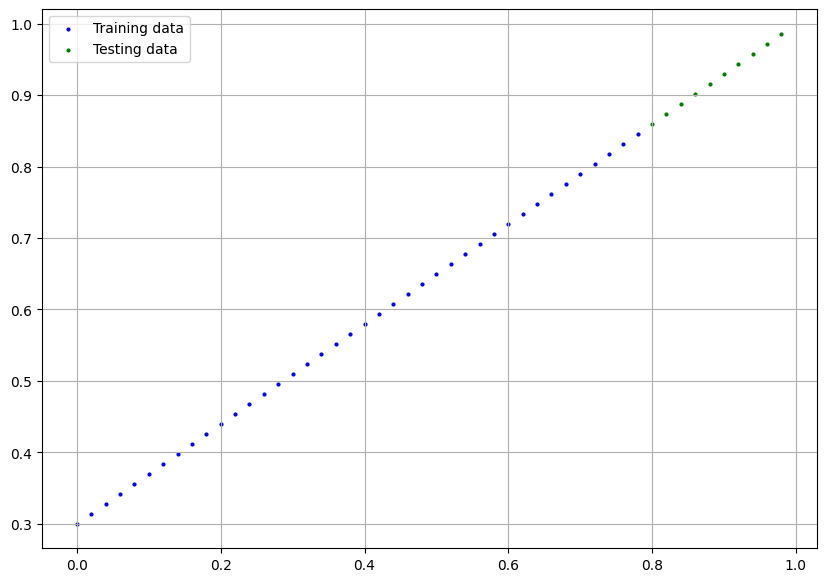

In [153]:
plot_predictions()

## 2. Build model

Now we've got some data, let's build a model to use the blue dots to predict the green dots.

Let's replicate a standard linear regression model using pure PyTorch.

In [154]:
class LinearRegressionModel(nn.Module):
    """
    This class defines a linear regression model using PyTorch
    """
    def __init__(self):
        super().__init__() # super() allows us to use methods from nn.Module
        self.weights = nn.Parameter(torch.randn(1, requires_grad = True, # requires_grad = True tells PyTorch to calculate gradients
                                                dtype = torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad = True,
                                             dtype= torch.float))
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        This function performs a forward pass of our model on input features X
        """
        return self.weights * X + self.bias

### PyTorch model building essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.optim`](https://pytorch.org/docs/stable/optim.html), [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html). For now, we'll focus on the first two and get to the other two later (though you may be able to guess what they do).

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  | 
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. | 
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). | 
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from `torch.nn`,
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within  `nn.Module`(s)
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-model-annotated.png" alt="Annotated building blocks of PyTorch" width="50%"/>

*Basic building blocks of creating a PyTorch model by subclassing `nn.Module`. For objects that subclass `nn.Module`, the `forward()` method must be defined.*

> **Resource:** See more of these essential modules and their uses cases in the [PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html). 


### Checking the contents of a PyTorch model
Now we've got these out of the way, let's create a model instance with the class we've made and check its parameters using [`.parameters()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters). 

In [155]:
# set manual seed since nn.parameters are randomly initialized
torch.manual_seed(42)

# instantiate our model
model_0 = LinearRegressionModel()

# check model weights and bias
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [156]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()` 
To check this we can pass it the test data `X_test` to see how closely it predicts `y_test`.

When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined. 

Let's make some predictions. 

In [157]:
# Make predictions with our model
# Inferences mode disables gradient calculation and backpropagation
with torch.inference_mode():
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

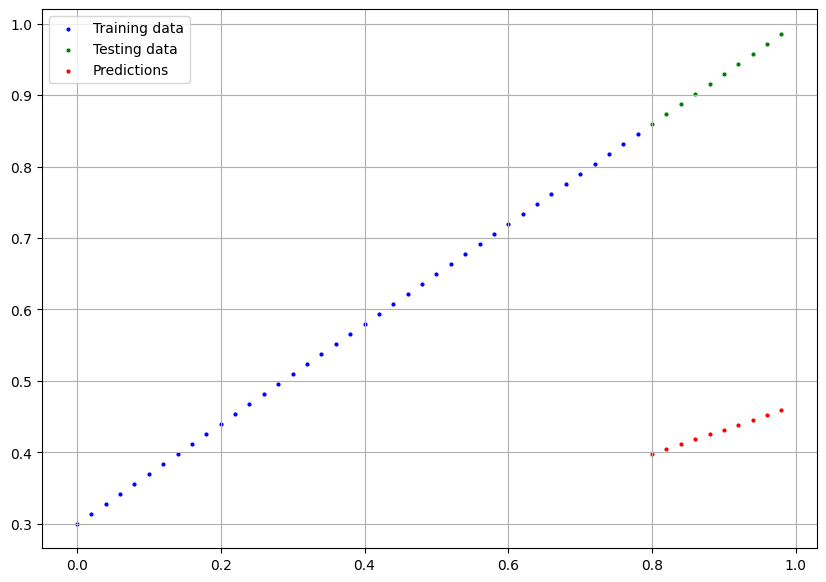

In [158]:
# Plot predictions
plot_predictions(predictions = y_preds)

We used [`torch.inference_mode()`](https://pytorch.org/docs/stable/generated/torch.inference_mode.html) as a [context manager](https://realpython.com/python-with-statement/) (that's what the `with torch.inference_mode():` is) to make the predictions.

As the name suggests, `torch.inference_mode()` is used when using a model for inference (making predictions).

`torch.inference_mode()` turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make **forward-passes** (data going through the `forward()` method) faster.

> **Note:** In older PyTorch code, you may also see `torch.no_grad()` being used for inference. While `torch.inference_mode()` and `torch.no_grad()` do similar things,
`torch.inference_mode()` is newer, potentially faster and preferred. See this [Tweet from PyTorch](https://twitter.com/PyTorch/status/1437838231505096708?s=20) for more.

We've made some predictions, let's see what they look like. 

## 3. Train model

Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

To fix that, we can update its internal parameters (I also refer to *parameters* as patterns), the `weights` and `bias` values we set randomly using `nn.Parameter()` and `torch.randn()` to be something that better represents the data.

To do this, we need two things:
1. **Loss function**: a function which tells our model how wrong it is (higher loss = wronger, lower loss = less wrong)
2. **Optimizer**: a function which tells our model how to improve its parameters (weights & biases) to reduce the loss function.

And specifically for PyTorch, we need:
- **Training loop**: a function which iterates through the training data, passes it to the model, calculates the loss, calculates the gradients of the loss with respect to the model, updates the model parameters using the optimizer and then repeats for a set number of epochs.
- **Evaluation loop**: a function which iterates through the test data, passes it to the model, calculates the loss, calculates the gradients of the loss with respect to the model, updates the model parameters using the optimizer and then repeats for a set number of epochs.

### Creating a loss function and optimizer in PyTorch

For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that's a **loss function** as well as an **optimizer**.

The rolls of these are: 

| Function | What does it do? | Where does it live in PyTorch? | Common values |
| ----- | ----- | ----- | ----- |
| **Loss function** | Measures how wrong your models predictions (e.g. `y_preds`) are compared to the truth labels (e.g. `y_test`). Lower the better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). | Mean absolute error (MAE) for regression problems ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Binary cross entropy for binary classification problems ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)).  |
| **Optimizer** | Tells your model how to update its internal parameters to best lower the loss. | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic gradient descent ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Adam optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)). | 

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems (predicting a number) or binary cross entropy loss function for classification problems (predicting one thing or another). 

For our problem, since we're predicting a number, let's use MAE (which is under `torch.nn.L1Loss()`) in PyTorch as our loss function. 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-mae-loss-annotated.png" alt="what MAE loss looks like for our plot data" width="40%"/>

*Mean absolute error (MAE, in PyTorch: `torch.nn.L1Loss`) measures the absolute difference between two points (predictions and labels) and then takes the mean across all examples.*

And we'll use SGD, `torch.optim.SGD(params, lr)` where:

* `params` is the target model parameters you'd like to optimize (e.g. the `weights` and `bias` values we randomly set before).
* `lr` is the **learning rate** you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The learning rate is considered a **hyperparameter** (because it's set by a machine learning engineer). Common starting values for the learning rate are `0.01`, `0.001`, `0.0001`, however, these can also be adjusted over time (this is called [learning rate scheduling](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)).

In [159]:
# Setup a loss function (Mean Absolute Error)
loss_fn = nn.L1Loss()

# Setup optimizer
optimizer = torch.optim.SGD(model_0.parameters(), lr = 1e-2)

### Creating an optimization loop in PyTorch

It's now time to create a **training loop** (and **testing loop**).

The training loop involves the model going through the training data and learning the relationships between the `features` and `labels`.

The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never see's the testing data during training).

Each of these is called a "loop" because we want our model to look (loop through) at each sample in each dataset.



### PyTorch training loop
For the training loop, we'll build the following steps:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_train)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)` | 
| 3 | Zero gradients | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()` |
| 4 | Perform backpropagation on the loss | Computes the gradient of the loss with respect for every model parameter to be updated  (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence "backwards".  | `loss.backward()` |
| 5 | Update the optimizer (**gradient descent**) | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them. | `optimizer.step()` |

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-training-loop-annotated.png" alt="an example of a pytorch training loop" width="50%"/>

> **Note:** The above is just one example of how the steps could be ordered or described. With experience you'll find making PyTorch training loops can be quite flexible.
>
> And on the ordering of things, the above is a good default order but you may see slightly different orders. Some rules of thumb: 
> * Calculate the loss (`loss = ...`) *before* performing backpropagation on it (`loss.backward()`).
> * Zero gradients (`optimizer.zero_grad()`) *before* stepping them (`optimizer.step()`).
> * Step the optimizer (`optimizer.step()`) *after* performing backpropagation on the loss (`loss.backward()`).

For resources to help understand what's happening behind the scenes with backpropagation and gradient descent, see the extra-curriculum section.



### PyTorch testing loop

As for the testing loop (evaluating our model), the typical steps include:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_test)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_test)` | 
| 3 | Calulate evaluation metrics (optional) | Alongisde the loss value you may want to calculate other evaluation metrics such as accuracy on the test set. | Custom functions |

Notice the testing loop doesn't contain performing backpropagation (`loss.backward()`) or stepping the optimizer (`optimizer.step()`), this is because no parameters in the model are being changed during testing, they've already been calculated. For testing, we're only interested in the output of the forward pass through the model.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-testing-loop-annotated.png" alt="an example of a pytorch testing loop" width="50%"/>

Let's put all of the above together and train our model for 100 **epochs** (forward passes through the data) and we'll evaluate it every 10 epochs.


In [160]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 200

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []
# Pass data through model for a number of epochs
for epoch in range(epochs):
    ### Training Phase ###
    
    # Put model in training mode
    model_0.train()
    # 1. Forward pass on train data using the forward() method of our model
    y_pred = model_0(X_train)
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    # 3. Zero the gradients of the optimizer
    optimizer.zero_grad()
    # 4. Backpropagation to calculate gradients
    loss.backward()
    # 5. Update the weights and bias
    optimizer.step()
    
    ### Evaluation Phase ###
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass on test data using the forward() method of our model
        y_test_pred = model_0(X_test)
        # 2. Calculate the loss
        test_loss = loss_fn(y_test_pred, y_test.type(torch.float))
        
        # tqdm progress bar to print results
        if epoch % 10 == 0 and epoch != 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch}/{epochs}  | MAE Train Loss: {loss:.4f} | MAE Test Loss: {test_loss:.4f} ")

Epoch: 10/200  | MAE Train Loss: 0.1977 | MAE Test Loss: 0.3464 
Epoch: 20/200  | MAE Train Loss: 0.0891 | MAE Test Loss: 0.2173 
Epoch: 30/200  | MAE Train Loss: 0.0531 | MAE Test Loss: 0.1446 
Epoch: 40/200  | MAE Train Loss: 0.0454 | MAE Test Loss: 0.1136 
Epoch: 50/200  | MAE Train Loss: 0.0417 | MAE Test Loss: 0.0992 
Epoch: 60/200  | MAE Train Loss: 0.0382 | MAE Test Loss: 0.0889 
Epoch: 70/200  | MAE Train Loss: 0.0348 | MAE Test Loss: 0.0806 
Epoch: 80/200  | MAE Train Loss: 0.0313 | MAE Test Loss: 0.0723 
Epoch: 90/200  | MAE Train Loss: 0.0279 | MAE Test Loss: 0.0647 
Epoch: 100/200  | MAE Train Loss: 0.0245 | MAE Test Loss: 0.0565 
Epoch: 110/200  | MAE Train Loss: 0.0210 | MAE Test Loss: 0.0482 
Epoch: 120/200  | MAE Train Loss: 0.0176 | MAE Test Loss: 0.0406 
Epoch: 130/200  | MAE Train Loss: 0.0142 | MAE Test Loss: 0.0323 
Epoch: 140/200  | MAE Train Loss: 0.0107 | MAE Test Loss: 0.0241 
Epoch: 150/200  | MAE Train Loss: 0.0073 | MAE Test Loss: 0.0165 
Epoch: 160/200  | M

## 4. Making predictions with a trained PyTorch model (inference)

Once you've trained a model, you'll likely want to make predictions with it.

We've already seen a glimpse of this in the training and testing code above, the steps to do it outside of the training/testing loop are similar.

There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

1. Set the model in evaluation mode (`model.eval()`).
2. Make the predictions using the inference mode context manager (`with torch.inference_mode(): ...`).
3. All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

The first two items make sure all helpful calculations and settings PyTorch uses behind the scenes during training but aren't necessary for inference are turned off (this results in faster computation). And the third ensures that you won't run into cross-device errors.

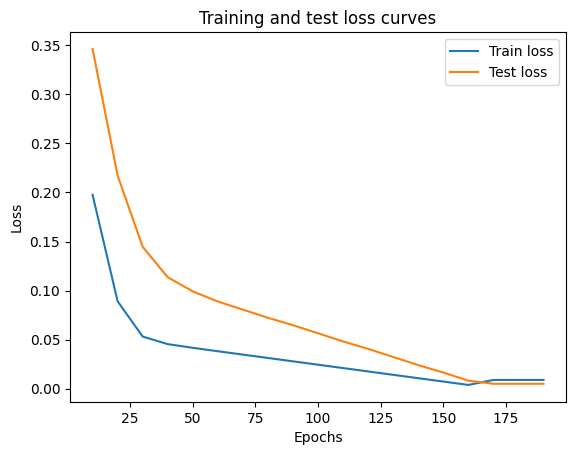

In [161]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [164]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

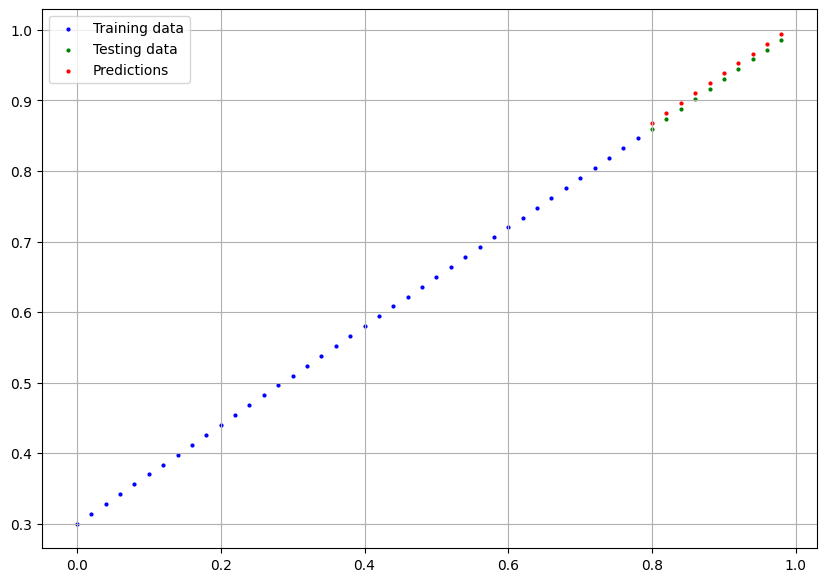

In [165]:
plot_predictions(predictions = y_preds)

In [163]:
# Print actual parameters
weight, bias, model_0.state_dict()

(0.7,
 0.3,
 OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))]))

## 5. Saving and loading a PyTorch model

If you've trained a PyTorch model, chances are you'll want to save it and export it somewhere.

As in, you might train it on Google Colab or your local machine with a GPU but you'd like to now export it to some sort of application where others can use it. 

Or maybe you'd like to save your progress on a model and come back and load it back later.

For saving and loading models in PyTorch, there are three main methods you should be aware of (all of below have been taken from the [PyTorch saving and loading models guide](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)):

| PyTorch method | What does it do? | 
| ----- | ----- |
| [`torch.save`](https://pytorch.org/docs/stable/torch.html?highlight=save#torch.save) | Saves a serialized object to disk using Python's [`pickle`](https://docs.python.org/3/library/pickle.html) utility. Models, tensors and various other Python objects like dictionaries can be saved using `torch.save`.  | 
| [`torch.load`](https://pytorch.org/docs/stable/torch.html?highlight=torch%20load#torch.load) | Uses `pickle`'s unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc). |
| [`torch.nn.Module.load_state_dict`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=load_state_dict#torch.nn.Module.load_state_dict)| Loads a model's parameter dictionary (`model.state_dict()`) using a saved `state_dict()` object. | 

> **Note:** As stated in [Python's `pickle` documentation](https://docs.python.org/3/library/pickle.html), the `pickle` module **is not secure**. That means you should only ever unpickle (load) data you trust. That goes for loading PyTorch models as well. Only ever use saved PyTorch models from sources you trust.

In [166]:
from pathlib import Path
import os

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "model_0.pth"
MODEL_SAVE_PATH = os.path.join(MODEL_PATH, MODEL_NAME)

# 3. Save model's state_dict
print(f"Saving model state_dict at: {MODEL_SAVE_PATH}")
torch.save(model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model state_dict at: models\model_0.pth


### Loading a saved PyTorch model's `state_dict()`

Since we've now got a saved model `state_dict()` at `models/01_pytorch_workflow_model_0.pth` we can now load it in using `torch.nn.Module.load_state_dict(torch.load(f))` where `f` is the filepath of our saved model `state_dict()`.

Why call `torch.load()` inside `torch.nn.Module.load_state_dict()`? 

Because we only saved the model's `state_dict()` which is a dictionary of learned parameters and not the *entire* model, we first have to load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of `nn.Module`).

Why not save the entire model?

[Saving the entire model](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model) rather than just the `state_dict()` is more intuitive, however, to quote the PyTorch documentation (italics mine):

> The disadvantage of this approach *(saving the whole model)* is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...
>
> Because of this, your code can break in various ways when used in other projects or after refactors.

So instead, we're using the flexible method of saving and loading just the `state_dict()`, which again is basically a dictionary of model parameters.

Let's test it out by created another instance of `LinearRegressionModel()`, which is a subclass of `torch.nn.Module` and will hence have the in-built method `load_state_dict()`.

In [168]:
# 1. Create model instance
loaded_model_0 = LinearRegressionModel()

# 2. Load model parameters from saved file
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

# 3. Set model in evaluation/inference mode
loaded_model_0.eval()
with torch.inference_mode():
    # 4. Make predictions
    y_preds = loaded_model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

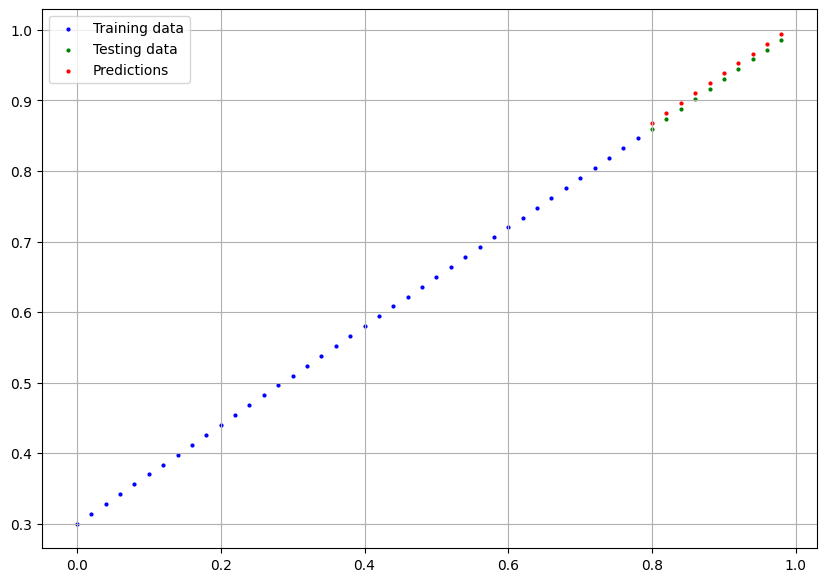

In [169]:
plot_predictions(predictions = y_preds)

In [170]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [171]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

## 6. Putting it all together 

This time we'll make our code device agnostic (so if there's a GPU available, it'll use it and if not, it will default to the CPU). 

In [172]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1+cu117'

In [173]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 6.1 Data

First, we'll hard-code some `weight` and `bias` values.

Then we'll make a range of numbers between 0 and 1, these will be our `X` values.

Finally, we'll use the `X` values, as well as the `weight` and `bias` values to create `y` using the linear regression formula (`y = weight * X + bias`).

In [187]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias

In [188]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

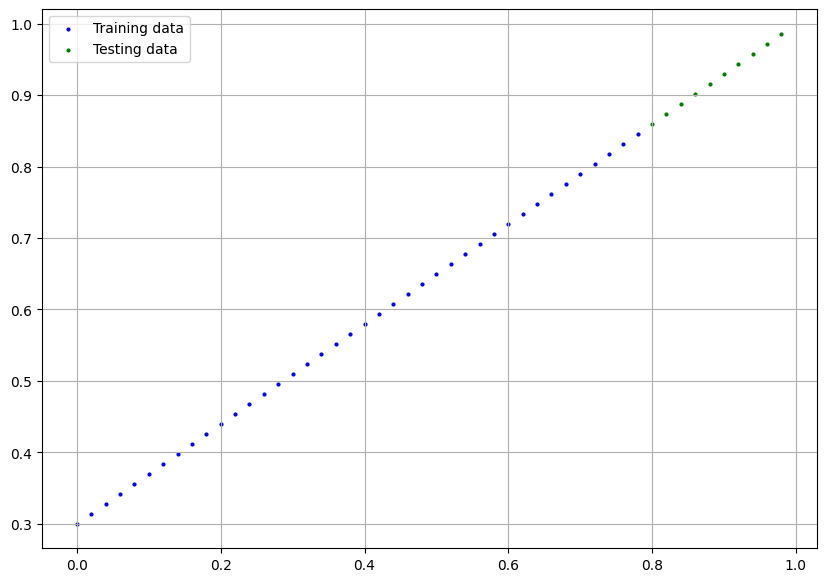

In [189]:
# Note: If you've reset your runtime, this function won't work, 
# you'll have to rerun the cell above where it's instantiated.
plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch linear model

We'll create the same style of model as before except this time, instead of defining the weight and bias parameters of our model manually using `nn.Parameter()`, we'll use [`nn.Linear(in_features, out_features)`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to do it for us.

Where `in_features` is the number of dimensions your input data has and `out_features` is the number of dimensions you'd like it to be output to.

In our case, both of these are `1` since our data has `1` input feature (`X`) per label (`y`).

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-regression-model-with-nn-Parameter-and-nn-Linear-compared.png" alt="Anatomy of a PyTorch model" width="50%"/>


*Creating a linear regression model using `nn.Parameter` versus using `nn.Linear`. There are plenty more examples of where the `torch.nn` module has pre-built computations, including many popular and useful neural network layers.*


In [190]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

Notice the outputs of `model_1.state_dict()`, the `nn.Linear()` layer created a random `weight` and `bias` parameter for us.

Now let's put our model on the GPU (if it's available).

We can change the device our PyTorch objects are on using `.to(device)`.

In [191]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [192]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

Time to build a training and testing loop.

First we'll need a loss function and an optimizer.

Let's use the same functions we used earlier, `nn.L1Loss()` and `torch.optim.SGD()`.

We'll have to pass the new model's parameters (`model.parameters()`) to the optimizer for it to adjust them during training. 

The learning rate of `0.01` worked well before too so let's use that again.

In [193]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)

We've already put our model on the target `device` using `model_1.to(device)`.

And we can do the same with the data.

That way if the model is on the GPU, the data is on the GPU (and vice versa).

Let's step things up a notch this time and set `epochs=1000`.

If you need a reminder of the PyTorch training loop steps, see below.

<details>
    <summary>PyTorch training loop steps</summary>
    <ol>
        <li><b>Forward pass</b> - The model goes through all of the training data once, performing its
            <code>forward()</code> function
            calculations (<code>model(x_train)</code>).
        </li>
        <li><b>Calculate the loss</b> - The model's outputs (predictions) are compared to the ground truth and evaluated
            to see how
            wrong they are (<code>loss = loss_fn(y_pred, y_train</code>).</li>
        <li><b>Zero gradients</b> - The optimizers gradients are set to zero (they are accumulated by default) so they
            can be
            recalculated for the specific training step (<code>optimizer.zero_grad()</code>).</li>
        <li><b>Perform backpropagation on the loss</b> - Computes the gradient of the loss with respect for every model
            parameter to
            be updated (each parameter
            with <code>requires_grad=True</code>). This is known as <b>backpropagation</b>, hence "backwards"
            (<code>loss.backward()</code>).</li>
        <li><b>Step the optimizer (gradient descent)</b> - Update the parameters with <code>requires_grad=True</code>
            with respect to the loss
            gradients in order to improve them (<code>optimizer.step()</code>).</li>
    </ol>
</details>

In [194]:
torch.manual_seed(42)

# Set number of epochs
epochs = 1000

# put data on the available device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training Phase ###
    model_1.train()
    # 1. Forward pass
    y_train_pred = model_1(X_train)
    # 2. Calculate loss
    loss = loss_fn(y_train_pred, y_train)
    # 3. Zero out the gradients
    optimizer.zero_grad()
    # 4. Calculate gradients
    loss.backward()
    # 5. Update the weights
    optimizer.step()
    
    ## Evaluation Phase ##
    model_1.eval()
    # 1. Forward pass
    with torch.inference_mode():
        y_test_pred = model_1(X_test)
        # 2. Calculate loss
        test_loss = loss_fn(y_test_pred, y_test)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}/{epochs}  | MAE Train Loss: {loss:.4f} | MAE Test Loss: {test_loss:.4f} ")

Epoch: 0/1000  | MAE Train Loss: 0.5552 | MAE Test Loss: 0.5740 
Epoch: 100/1000  | MAE Train Loss: 0.0062 | MAE Test Loss: 0.0141 
Epoch: 200/1000  | MAE Train Loss: 0.0013 | MAE Test Loss: 0.0138 
Epoch: 300/1000  | MAE Train Loss: 0.0013 | MAE Test Loss: 0.0138 
Epoch: 400/1000  | MAE Train Loss: 0.0013 | MAE Test Loss: 0.0138 
Epoch: 500/1000  | MAE Train Loss: 0.0013 | MAE Test Loss: 0.0138 
Epoch: 600/1000  | MAE Train Loss: 0.0013 | MAE Test Loss: 0.0138 
Epoch: 700/1000  | MAE Train Loss: 0.0013 | MAE Test Loss: 0.0138 
Epoch: 800/1000  | MAE Train Loss: 0.0013 | MAE Test Loss: 0.0138 
Epoch: 900/1000  | MAE Train Loss: 0.0013 | MAE Test Loss: 0.0138 


> **Note:** Due to the random nature of machine learning, you will likely get slightly different results (different loss and prediction values) depending on whether your model was trained on CPU or GPU. This is true even if you use the same random seed on either device. If the difference is large, you may want to look for errors, however, if it is small (ideally it is), you can ignore it.


Let's check the parameters our model has learned and compare them to the original parameters we hard-coded.

In [195]:
from pprint import pprint
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


### 6.4 Making predictions

Now we've got a trained model, let's turn on it's evaluation mode and make some predictions.

In [196]:
model_1.eval()
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

If you're making predictions with data on the GPU, you might notice the output of the above has `device='cuda:0'` towards the end. That means the data is on CUDA device 0 (the first GPU your system has access to due to zero-indexing), if you end up using multiple GPUs in the future, this number may be higher. 

Now let's plot our model's predictions.

> **Note:** Many data science libraries such as pandas, matplotlib and NumPy aren't capable of using data that is stored on GPU. So you might run into some issues when trying to use a function from one of these libraries with tensor data not stored on the CPU. To fix this, you can call [`.cpu()`](https://pytorch.org/docs/stable/generated/torch.Tensor.cpu.html) on your target tensor to return a copy of your target tensor on the CPU.

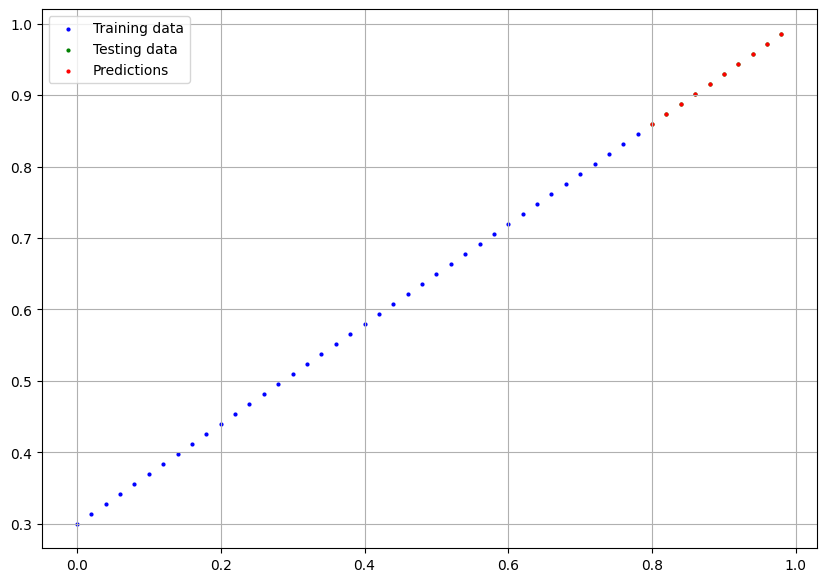

In [197]:
# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

### 6.5 Saving and loading a model

We're happy with our models predictions, so let's save it to file so it can be used later.

In [198]:
from pathlib import Path
# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "model_1.pth"
MODEL_SAVE_PATH = os.path.join(MODEL_PATH, MODEL_NAME)

# 3. Save model's state_dict
print(f"Saving model state_dict at: {MODEL_SAVE_PATH}")
torch.save(model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model state_dict at: models\model_1.pth


In [199]:
# 1. Create model instance
loaded_model_1 = LinearRegressionModelV2()

# 2. Load model parameters from saved file
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# 3. put model in the device it was trained on
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [200]:
# 4. Make predictions
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')